# <span style = "color:red"> MNIST (Binary Classifier) </span>

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')



In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36011]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print(y[36011])

<Figure size 640x480 with 1 Axes>

5


In [4]:
import numpy as np

X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]
y_train = y_train.astype(np.int8) 

In [5]:
#Shuffle the dataset

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## <span style = "color:blue"> Training a Binary Classifier</span>

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

## <span style = "color:blue"> Measuring Accuracy Using Cross-Validation </span>

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

#This happened because just 10% of images are 5's, so even if you guess that all images were not a 5, you will be right almost 90%
#Some classes are much more frequent than others

array([0.96715, 0.9267 , 0.9601 ])

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [11]:
confusion_matrix(y_train_5, y_train_pred)


array([[52557,  2022],
       [  899,  4522]], dtype=int64)

## <span style = "color:blue"> Confusion Matrix </span>

In [12]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #  When a model claims an image of 5, it is correct only: 2832 / (2832 + 272)

0.6910146699266504

In [13]:
recall_score(y_train_5, y_train_pred) # It only detects: 2832 / (2832 + 2589) of 5's

0.8341634384799852

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.755871291266193

## <span style = "color:blue"> Precision/Recall Tradeoff</span>

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([7676.46080553])

In [16]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

#Code returns the same result as the predict method, because SGDClassifier uses a threshold = 0

array([ True])

In [17]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#Raising the threshold decreases recall

array([False])

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

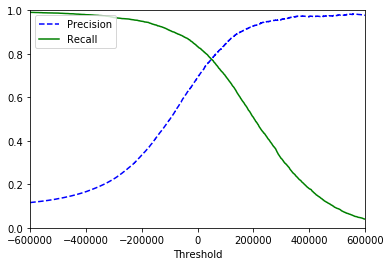

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = "Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])
    plt.xlim([-600000, 600000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

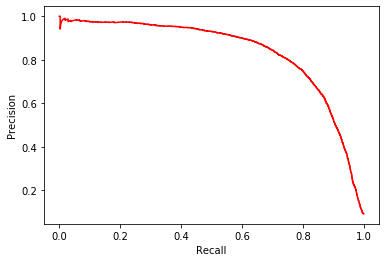

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.xlabel("Recall")
    plt.ylabel("Precision")

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [22]:
y_train_pred_90 = (y_scores > 70000)
#If you look up the first plot, you would conclude that your threshold should be around 70 000(for acc of 90%)

In [23]:
precision_score(y_train_5, y_train_pred_90)

0.8059880239520958

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.7448810182623132

## <span style = "color:blue"> The ROC curve </span>

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

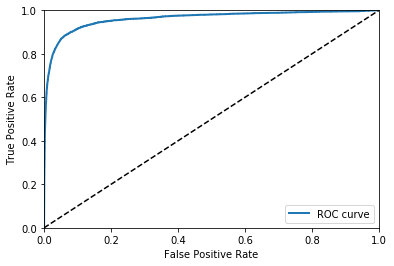

In [26]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = "lower right")

plot_roc_curve(fpr, tpr, "ROC curve")
plt.show()
    

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.961555004122566

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

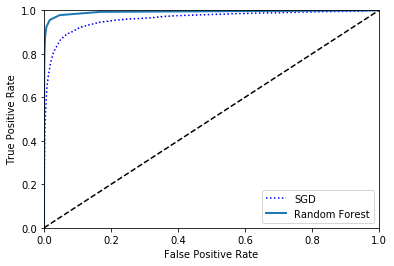

In [29]:
y_scores_forest = y_probas_forest[:, 1] #score probas of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926880764308552

In [31]:
precision_score(y_train_5, y_scores_forest.round())

0.9821192052980132

In [32]:
recall_score(y_train_5, y_scores_forest.round())

0.8206972883231876